In [ ]:
#!pip install darts

In [51]:
import gdown
import numpy as np
import pandas as pd
from darts import TimeSeries
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox


from darts.utils.statistics import plot_acf, plot_pacf, acf, pacf

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [54]:
# Descarga directa de la base de datos
file_id = "1g-X07pjlSiAn2jeYCOD3lWs5_RMQsO9U"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "icap_90_24.txt", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1g-X07pjlSiAn2jeYCOD3lWs5_RMQsO9U
To: /content/icap_90_24.txt
100%|██████████| 3.29k/3.29k [00:00<00:00, 7.59MB/s]


'icap_90_24.txt'

In [55]:
df = pd.read_table('icap_90_24.txt', header = None, decimal=',')
df.columns = ['icap']
display(df.head(6))
df.info()

,icap
0,102.45
1,96.72
2,106.45
3,103.26
4,100.50
5,96.01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   icap    412 non-null    float64
dtypes: float64(1)
memory usage: 3.3 KB


In [ ]:
# MS: Inicio de mes, M: final del mes, D: diaria, H: por hora
df['fecha'] = pd.date_range(start='1990-01', end='2024-04', freq='MS')
df.set_index('fecha', inplace=True)
df.index = pd.to_datetime(df.index)
display(df.head(10))
df_series = TimeSeries.from_series(df['icap'])
display(df_series.head(10))
df_train, df_val = df_series.split_before(pd.Timestamp('2023-10'))

,icap
fecha,
1990-01-01,102.45
1990-02-01,96.72
1990-03-01,106.45
1990-04-01,103.26
1990-05-01,100.50
1990-06-01,96.01
1990-07-01,90.98
1990-08-01,98.82
1990-09-01,101.21


<TimeSeries (DataArray) (fecha: 10, component: 1, sample: 1)> Size: 80B
array([[[102.45]],

       [[ 96.72]],

       [[106.45]],

       [[103.26]],

       [[100.5 ]],

       [[ 96.01]],

       [[ 90.98]],

       [[ 98.82]],

       [[101.21]],

       [[ 98.59]]])
Coordinates:
  * fecha      (fecha) datetime64[ns] 80B 1990-01-01 1990-02-01 ... 1990-10-01
  * component  (component) <U4 16B 'icap'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

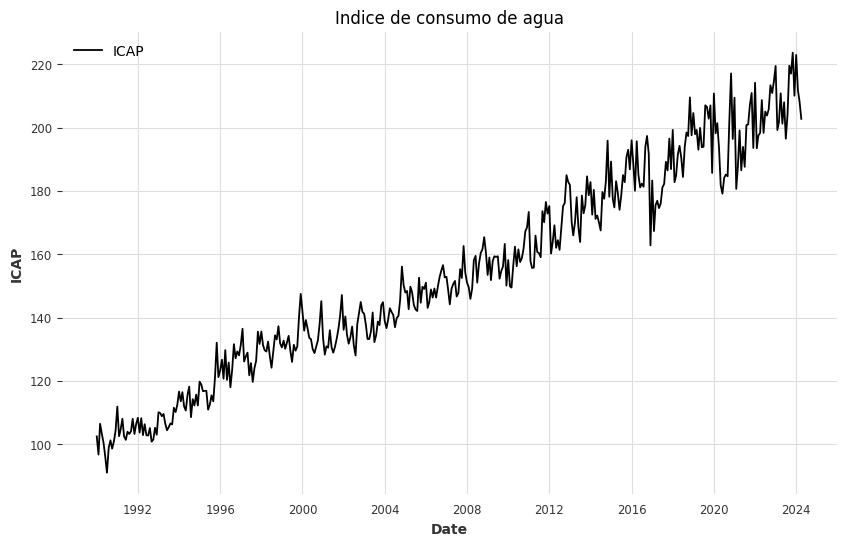

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['icap'], label='ICAP')
plt.title('Indice de consumo de agua')
plt.xlabel('Date')
plt.ylabel('ICAP')
plt.legend()
plt.show()

In [ ]:
# Aplicar transformación Box-Cox
df['icap_boxcox'], lmbda = boxcox(df['icap'])
print(f'El valor de lambda es: {lmbda:.2f}')
df.head(10)

El valor de lambda es: 0.43


,icap,icap_boxcox
fecha,,
1990-01-01,102.45,14.826792
1990-02-01,96.72,14.405121
1990-03-01,106.45,15.113277
1990-04-01,103.26,14.885311
1990-05-01,100.50,14.684829
1990-06-01,96.01,14.351896
1990-07-01,90.98,13.968257
1990-08-01,98.82,14.561264
1990-09-01,101.21,14.736697


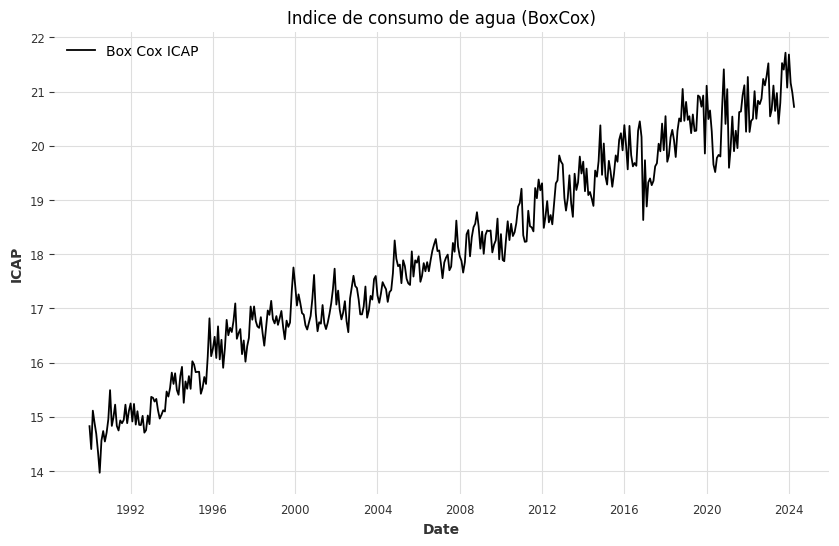

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['icap_boxcox'], label='Box Cox ICAP')
plt.title('Indice de consumo de agua (BoxCox)')
plt.xlabel('Date')
plt.ylabel('ICAP')
plt.legend()
plt.show()

In [ ]:
df['icap_diff'] = df['icap'].diff().dropna()
df.head(10)

,icap,icap_boxcox,icap_diff
fecha,,,
1990-01-01,102.45,14.826792,NaN
1990-02-01,96.72,14.405121,-5.73
1990-03-01,106.45,15.113277,9.73
1990-04-01,103.26,14.885311,-3.19
1990-05-01,100.50,14.684829,-2.76
1990-06-01,96.01,14.351896,-4.49
1990-07-01,90.98,13.968257,-5.03
1990-08-01,98.82,14.561264,7.84
1990-09-01,101.21,14.736697,2.39


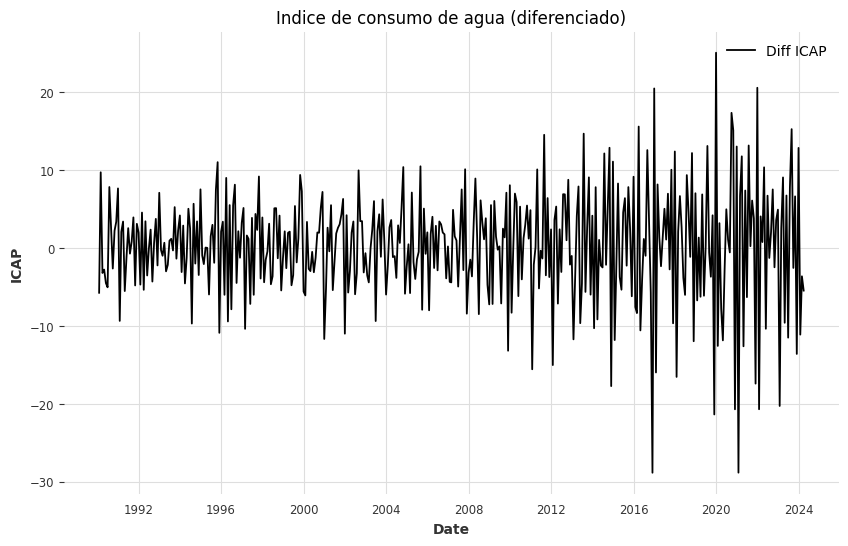

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['icap_diff'], label='Diff ICAP')
plt.title('Indice de consumo de agua (diferenciado)')
plt.xlabel('Date')
plt.ylabel('ICAP')
plt.legend()
plt.grid(True)
plt.show()

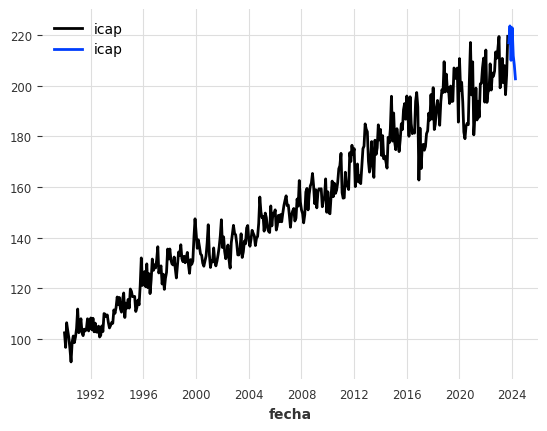

In [ ]:
df_train.plot()
df_val.plot()
plt.show()

In [ ]:
train_data_np = df_train.values().squeeze()
train_data = pd.DataFrame(train_data_np)
model = ExponentialSmoothing(train_data, trend = 'add', seasonal=None)
result = model.fit()
alpha = result.params['smoothing_level']
beta = result.params['smoothing_trend']

In [ ]:
print(f'El valor de alpha es: {alpha:.4f}')
print(f'El valor de beta es: {beta:.4f}')

El valor de alpha es: 0.3346
El valor de beta es: 0.0000


In [ ]:
beta

np.float64(0.0)

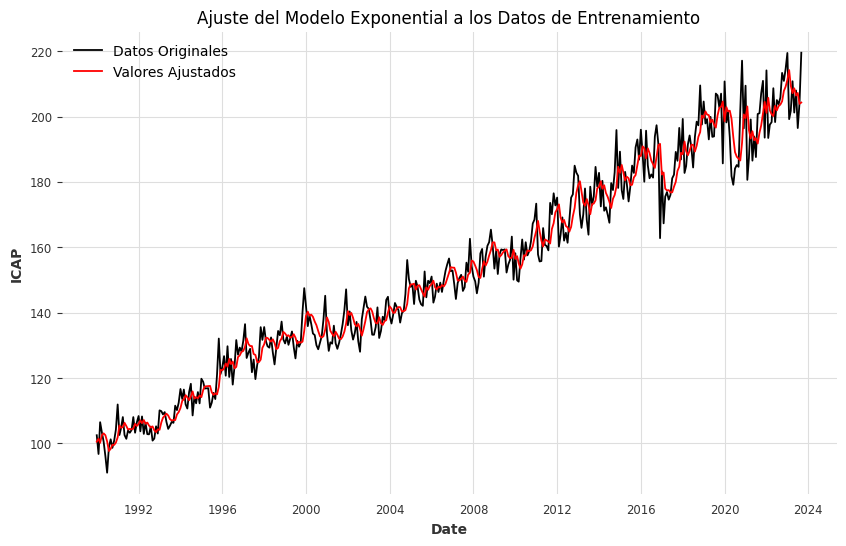

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[0:405], df['icap'][0:405], label='Datos Originales')
plt.plot(df.index[0:405], result.fittedvalues, label='Valores Ajustados', color='red')
plt.title('Ajuste del Modelo Exponential a los Datos de Entrenamiento')
plt.xlabel('Date')
plt.ylabel('ICAP')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
val_data_np = df_val.values().squeeze()
val_data = pd.DataFrame(val_data_np)
forecast_holt = result.forecast(steps=len(val_data))
mse_holt = mean_squared_error(val_data, forecast_holt)

In [ ]:
mse_holt

68.351608221148

In [ ]:
val_data

,0
0,216.99
1,223.63
2,210.05
3,222.91
4,211.81
5,208.19
6,202.74


In [ ]:
forecast_holt

,0
405,209.654661
406,209.924231
407,210.193802
408,210.463372
409,210.732943
410,211.002513
411,211.272084


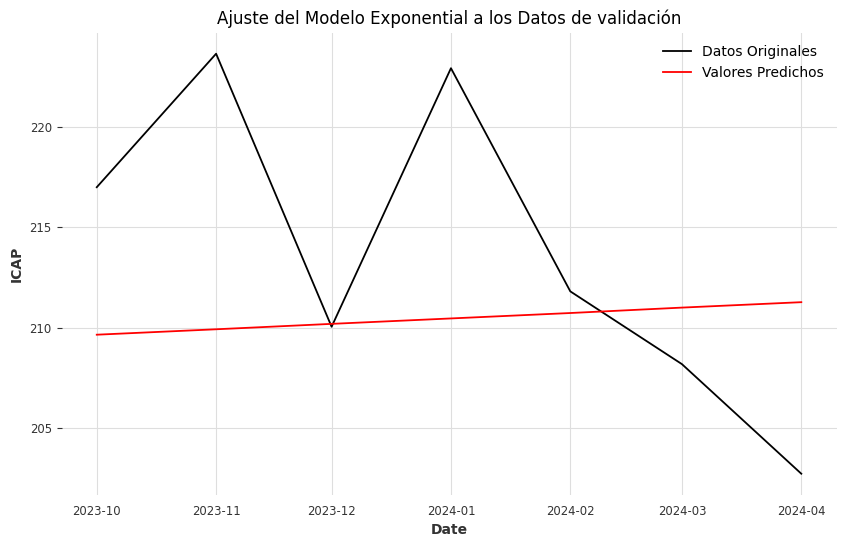

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[405:], df['icap'][405:], label='Datos Originales')
plt.plot(df.index[405:], forecast_holt, label='Valores Predichos', color='red')
plt.title('Ajuste del Modelo Exponential a los Datos de validación')
plt.xlabel('Date')
plt.ylabel('ICAP')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
decomposition_result = seasonal_decompose(train_data, model='additive', period=12)
estimated_trend = decomposition_result.trend.dropna()
estimated_seasonality = decomposition_result.seasonal.dropna()

In [ ]:
poly = PolynomialFeatures(degree=3)
X = np.arange(len(estimated_trend)).reshape(-1, 1)
y = estimated_trend.values
X_poly = poly.fit_transform(X)

In [ ]:
dates_future = pd.date_range(start='2023-10', end='2024-04', freq='MS')
X_future = np.arange(len(estimated_trend), len(estimated_trend) + len(dates_future)).reshape(-1, 1)
X_future_poly = poly.transform(X_future)

In [ ]:
trend_model = LinearRegression()
trend_model.fit(X_poly, y)
predicted_poly_trend = trend_model.predict(X_future_poly)

In [ ]:
future_seasonality = estimated_seasonality[-12:].head(len(dates_future)).values
complete_poly_trend_pred = predicted_poly_trend + future_seasonality
complete_poly_trend_pred_pd = pd.Series(complete_poly_trend_pred, index=dates_future)

In [ ]:
complete_poly_trend_pred_pd

,0
2023-10-01,210.993930
2023-11-01,216.514706
2023-12-01,211.239966
2024-01-01,215.374411
2024-02-01,208.373221
2024-03-01,208.069255
2024-04-01,210.359423


In [ ]:
mse_poly_trend = mean_squared_error(val_data, complete_poly_trend_pred_pd)
mse_poly_trend

30.666146905100355